# CDFS SWIRE master catalogue
## Checks and diagnostics

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
2050429 (Mon Jul 17 18:20:18 2017 +0100)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
plt.style.use('ggplot')

import locale
locale.setlocale(locale.LC_ALL, 'en_GB')

import os
import time
import itertools

from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy import units as u
from astropy import visualization as vis
import numpy as np
from matplotlib_venn import venn3

from herschelhelp_internal.masterlist import nb_compare_mags, nb_ccplots, nb_histograms

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))
#SUFFIX = "_20170718"

master_catalogue = Table.read("{}/master_catalogue_cdfs-swire{}.fits".format(OUT_DIR, SUFFIX))
print('Using masterlist ' + "{}/master_catalogue_cdfs-swire{}.fits".format(OUT_DIR, SUFFIX))

Using masterlist ./data/master_catalogue_cdfs-swire_20170718.fits


## I - Summary of wavelength domains

In [4]:
flag_obs = master_catalogue['flag_optnir_obs']
flag_det = master_catalogue['flag_optnir_det']

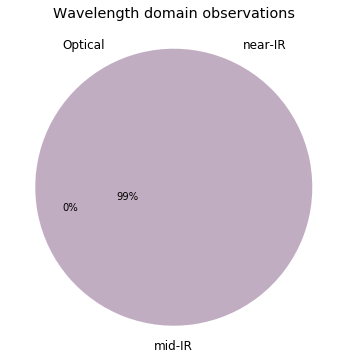

In [5]:
venn3(
    [
        np.sum(flag_obs == 4),
        np.sum(flag_obs == 2),
        np.sum(flag_obs == 6),
        np.sum(flag_obs == 1),
        np.sum(flag_obs == 5),
        np.sum(flag_obs == 3),
        np.sum(flag_obs == 7)
    ],
    set_labels=('Optical', 'near-IR', 'mid-IR'),
    subset_label_formatter=lambda x: "{}%".format(int(100*x/len(flag_obs)))
)
plt.title("Wavelength domain observations");

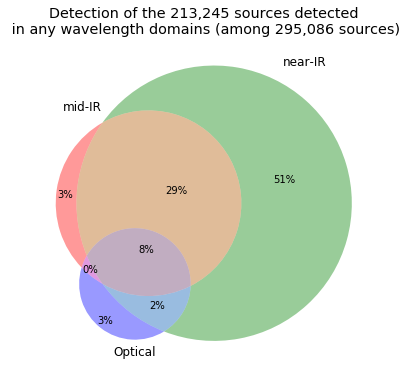

In [6]:
venn3(
    [
        np.sum(flag_det[flag_obs == 7] == 4),
        np.sum(flag_det[flag_obs == 7] == 2),
        np.sum(flag_det[flag_obs == 7] == 6),
        np.sum(flag_det[flag_obs == 7] == 1),
        np.sum(flag_det[flag_obs == 7] == 5),
        np.sum(flag_det[flag_obs == 7] == 3),
        np.sum(flag_det[flag_obs == 7] == 7)
    ],
    set_labels=('mid-IR', 'near-IR', 'Optical'),
    subset_label_formatter=lambda x: "{}%".format(int(100*x/np.sum(flag_det != 0)))
)
plt.title("Detection of the {} sources detected\n in any wavelength domains "
          "(among {} sources)".format(
              locale.format('%d', np.sum(flag_det != 0), grouping=True),
              locale.format('%d', len(flag_det), grouping=True)));

## II - Comparing magnitudes in similar filters

The master list if composed of several catalogues containing magnitudes in similar filters on different instruments. We are comparing the magnitudes in these corresponding filters.

In [7]:
u_bands = ["ATLAS u", "COMBO u"]
g_bands = ["ATLAS g",            "PS1 g"]
r_bands = ["ATLAS r", "COMBO r", "PS1 r"]
i_bands = ["ATLAS i", "COMBO i", "PS1 i"]
z_bands = ["ATLAS z",            "PS1 z"]
y_bands = [                      "PS1 y", "VIDEO y", "VHS y"]

### II.a - Comparing depths

We compare the histograms of the total aperture magnitudes of similar bands.

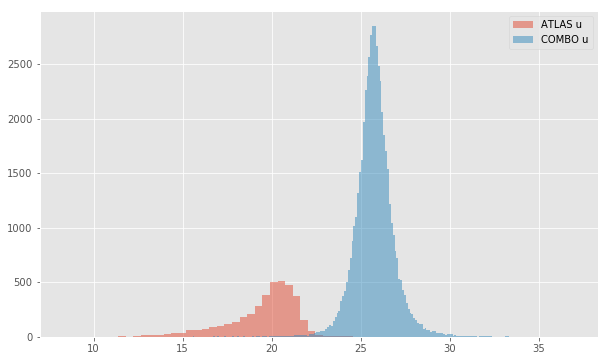

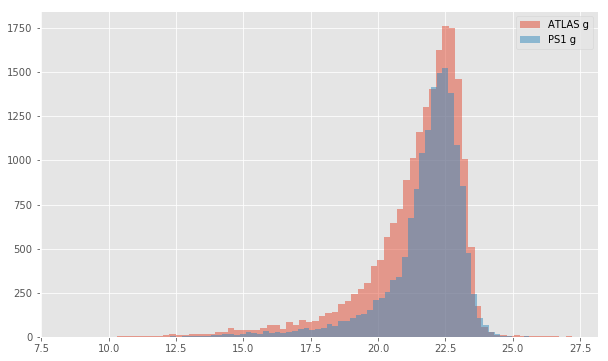

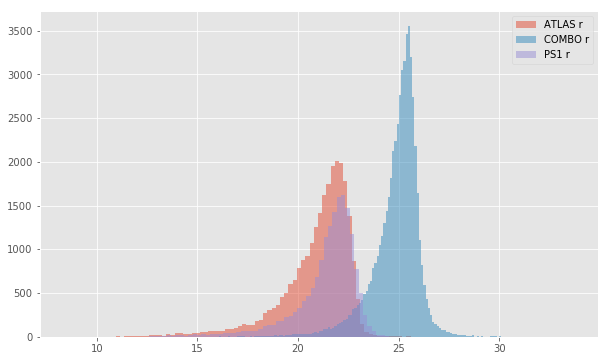

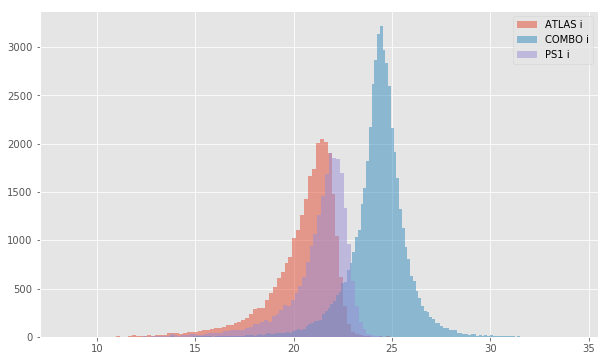

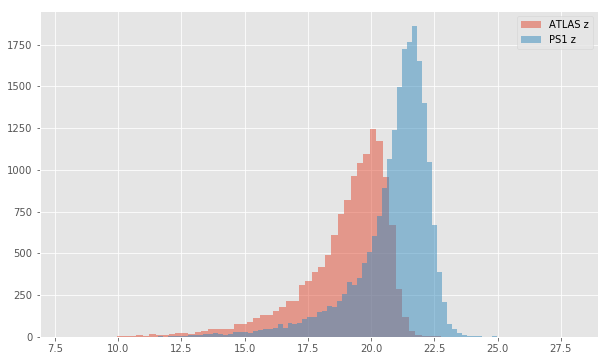

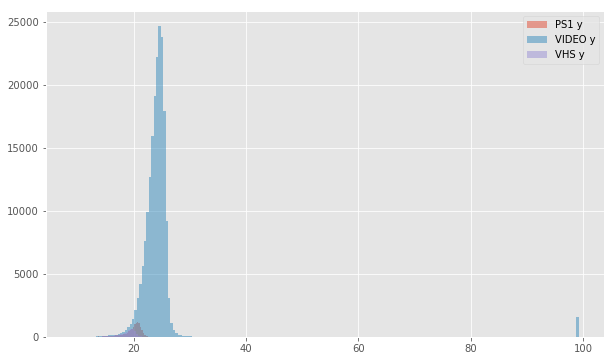

In [8]:
for bands in [u_bands, g_bands, r_bands, i_bands, z_bands, y_bands]:
    colnames = ["m_{}".format(band.replace(" ", "_").lower()) for band in bands]
    nb_histograms(master_catalogue, colnames, bands)

### II.b - Comparing magnitudes

We compare one to one each magnitude in similar bands.

There are no overlapping magnitudes...
COMBO u (total) - ATLAS u (total):
- Median: 0.29
- Median Absolute Deviation: 0.10
- 1% percentile: -0.25154247283935544
- 99% percentile: 4.609162139892546


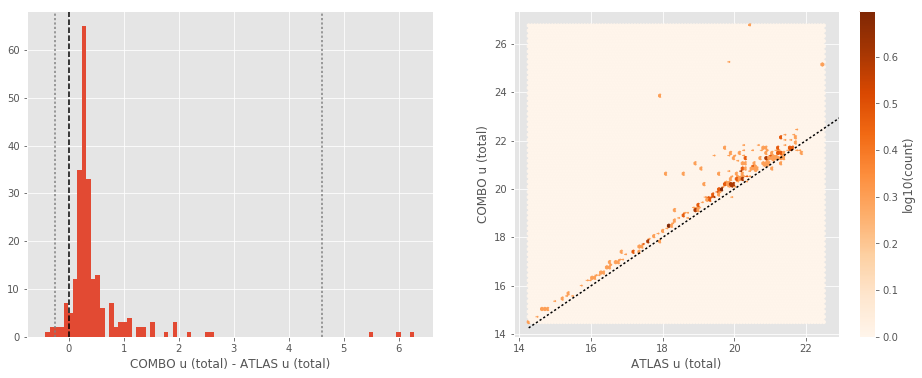

PS1 g (aperture) - ATLAS g (aperture):
- Median: -0.27
- Median Absolute Deviation: 0.26
- 1% percentile: -1.42533447265625
- 99% percentile: 1.6096204376220706


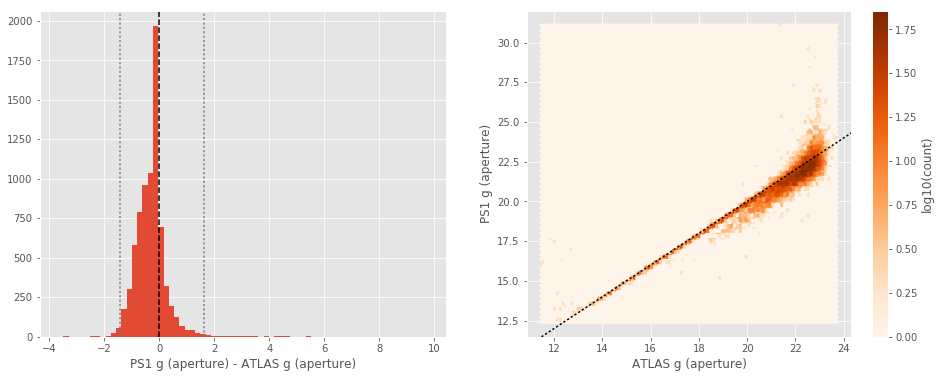

PS1 g (total) - ATLAS g (total):
- Median: -0.07
- Median Absolute Deviation: 0.16
- 1% percentile: -1.3469144439697267
- 99% percentile: 0.7755261230468751


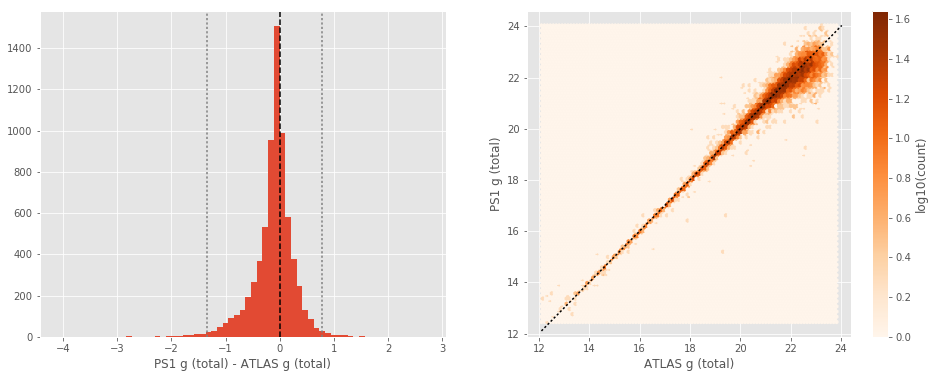

There are no overlapping magnitudes...
COMBO r (total) - ATLAS r (total):
- Median: 0.20
- Median Absolute Deviation: 0.32
- 1% percentile: -0.6571969413757324
- 99% percentile: 2.015692920684814


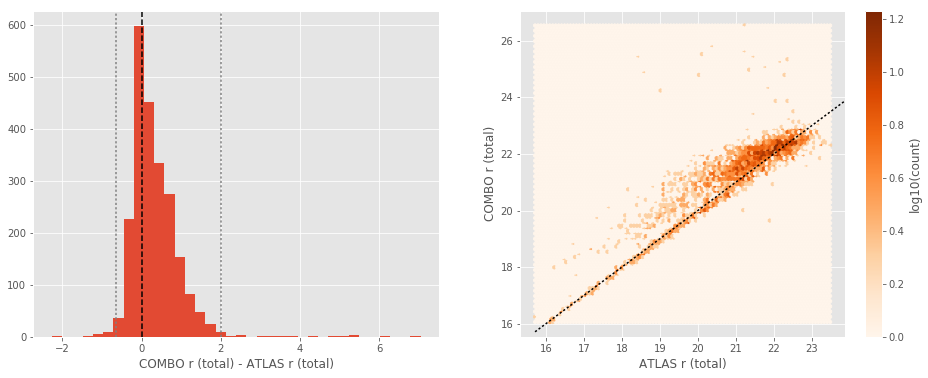

PS1 r (aperture) - ATLAS r (aperture):
- Median: -0.14
- Median Absolute Deviation: 0.22
- 1% percentile: -1.0578193473815918
- 99% percentile: 1.4797516822814913


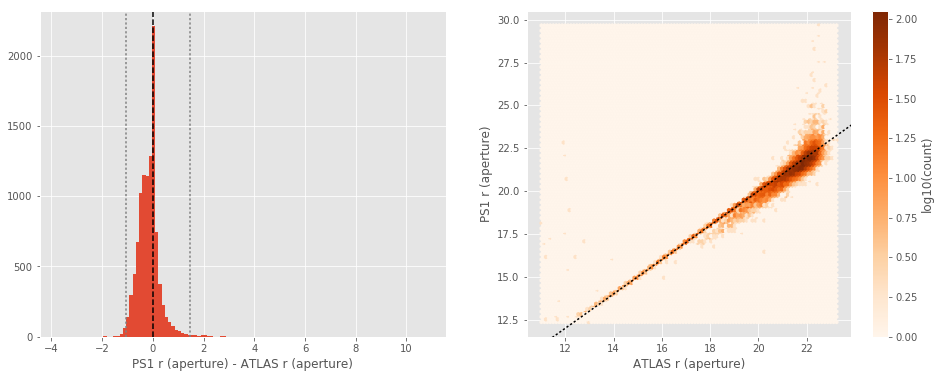

PS1 r (total) - ATLAS r (total):
- Median: 0.08
- Median Absolute Deviation: 0.15
- 1% percentile: -0.9342081451416016
- 99% percentile: 0.9685234069824209


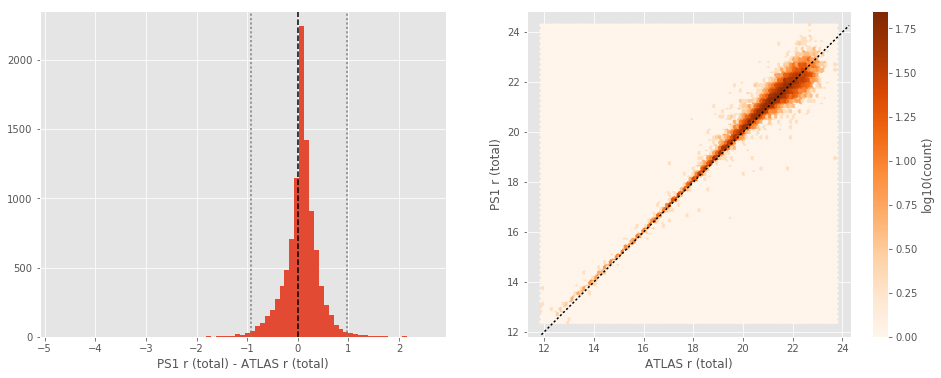

There are no overlapping magnitudes...
PS1 r (total) - COMBO r (total):
- Median: -0.25
- Median Absolute Deviation: 0.35
- 1% percentile: -1.8474485397338867
- 99% percentile: 0.7517166137695317


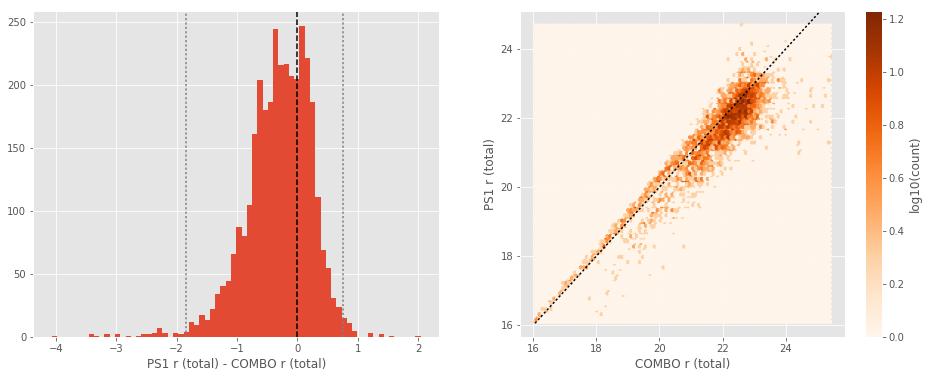

There are no overlapping magnitudes...
COMBO i (total) - ATLAS i (total):
- Median: 0.09
- Median Absolute Deviation: 0.36
- 1% percentile: -0.9963259696960449
- 99% percentile: 1.809000015258789


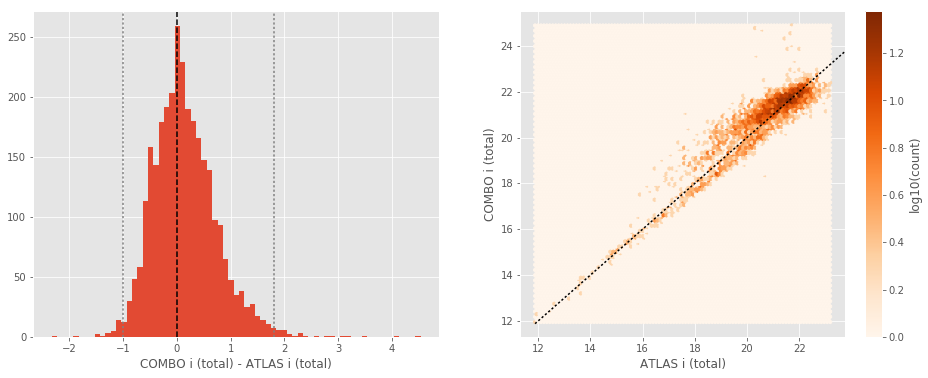

PS1 i (aperture) - ATLAS i (aperture):
- Median: -0.15
- Median Absolute Deviation: 0.19
- 1% percentile: -0.9456527709960938
- 99% percentile: 0.9547302246093751


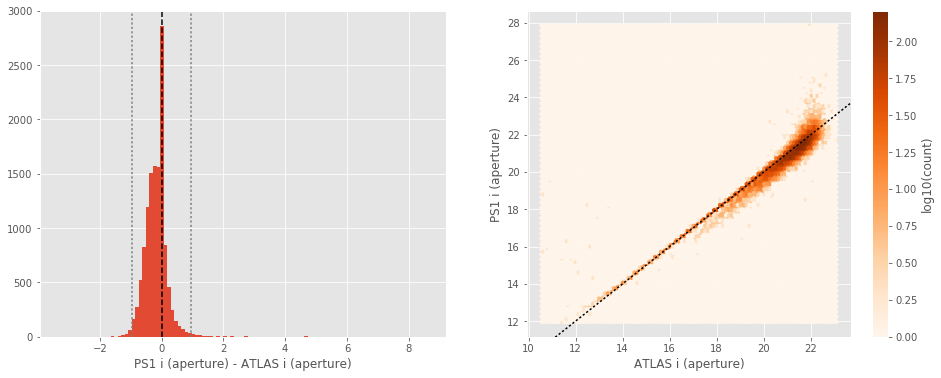

PS1 i (total) - ATLAS i (total):
- Median: 0.05
- Median Absolute Deviation: 0.14
- 1% percentile: -0.8313775634765624
- 99% percentile: 0.8947628402709951


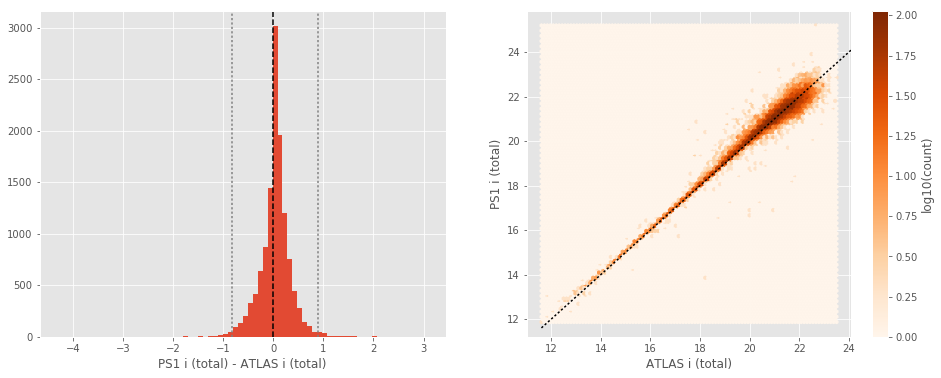

There are no overlapping magnitudes...
PS1 i (total) - COMBO i (total):
- Median: -0.11
- Median Absolute Deviation: 0.34
- 1% percentile: -1.6877352142333986
- 99% percentile: 1.0040975952148445


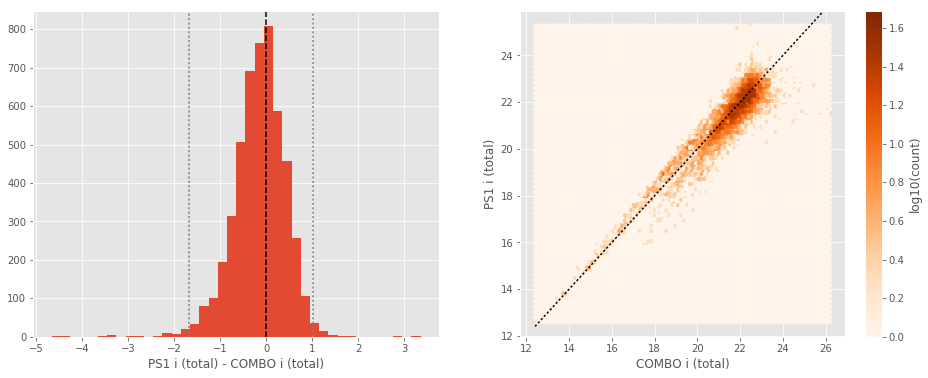

PS1 z (aperture) - ATLAS z (aperture):
- Median: 0.07
- Median Absolute Deviation: 0.12
- 1% percentile: -0.7832435798645019
- 99% percentile: 0.5602237319946284


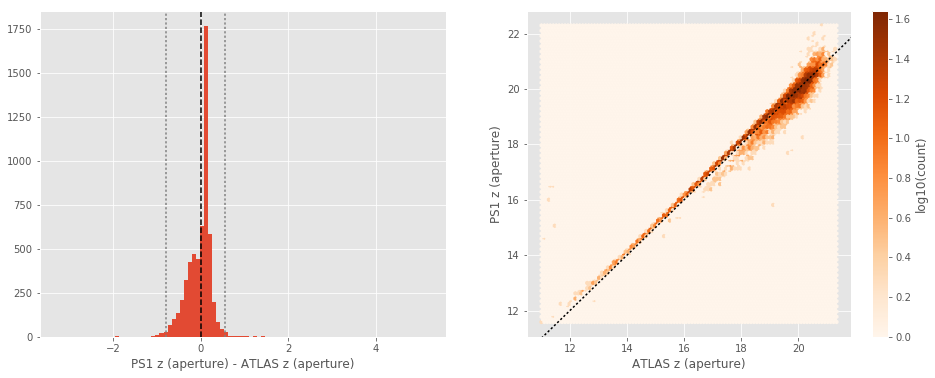

PS1 z (total) - ATLAS z (total):
- Median: 0.16
- Median Absolute Deviation: 0.10
- 1% percentile: -0.6337639236450195
- 99% percentile: 0.6781936264038085


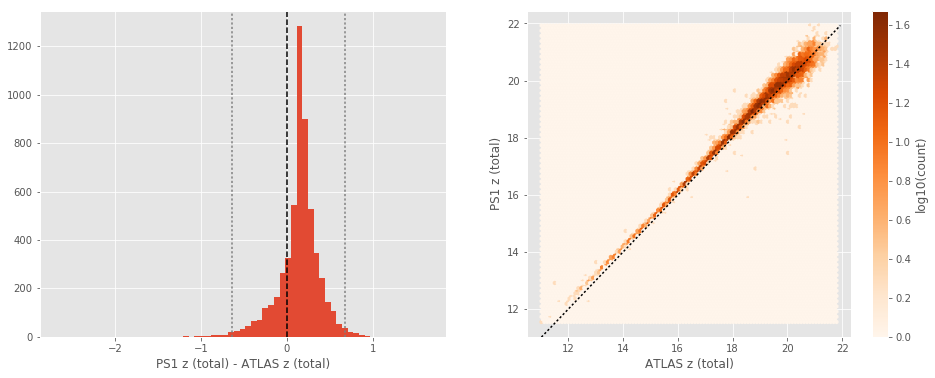

VIDEO y (aperture) - PS1 y (aperture):
- Median: 0.14
- Median Absolute Deviation: 0.31
- 1% percentile: -2.9529656600952148
- 99% percentile: 2.1896960067749065


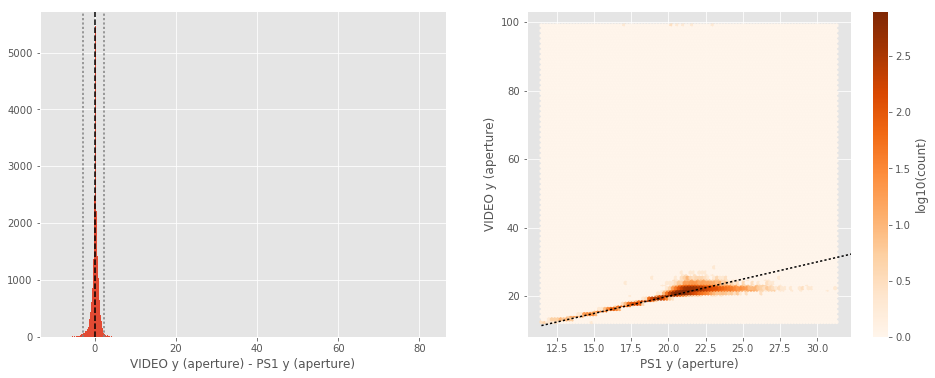

VIDEO y (total) - PS1 y (total):
- Median: -0.17
- Median Absolute Deviation: 0.16
- 1% percentile: -0.9953070831298828
- 99% percentile: 1.2740784835815318


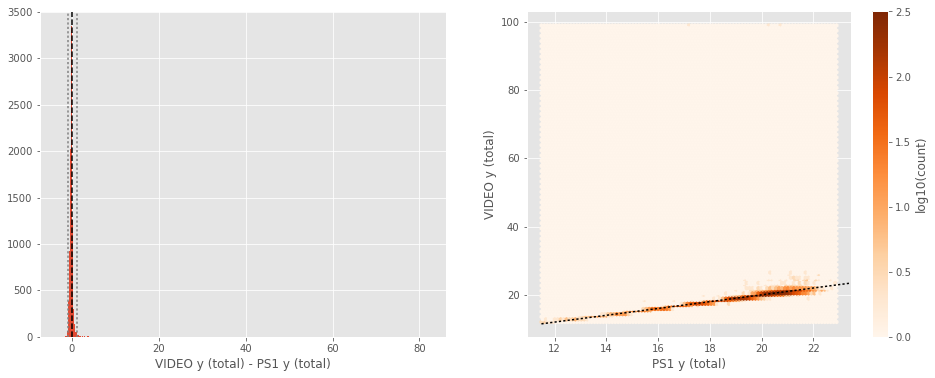

VHS y (aperture) - PS1 y (aperture):
- Median: -0.61
- Median Absolute Deviation: 0.16
- 1% percentile: -1.9730397987365724
- 99% percentile: 0.16049924850463768


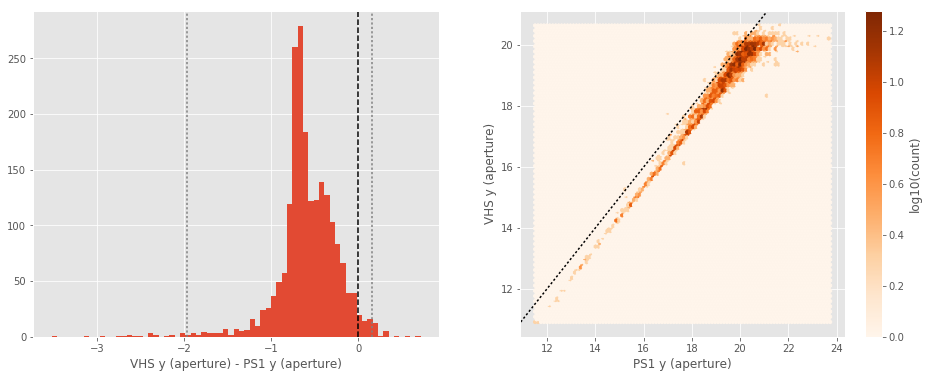

VHS y (total) - PS1 y (total):
- Median: -0.78
- Median Absolute Deviation: 0.16
- 1% percentile: -1.6478675079345702
- 99% percentile: 0.31035629272460924


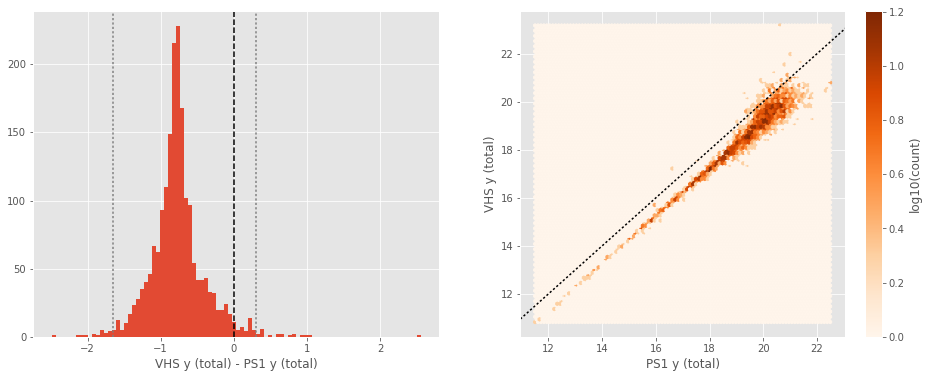

VHS y (aperture) - VIDEO y (aperture):
- Median: -0.69
- Median Absolute Deviation: 0.10
- 1% percentile: -1.489771270751953
- 99% percentile: -0.18053092956543054


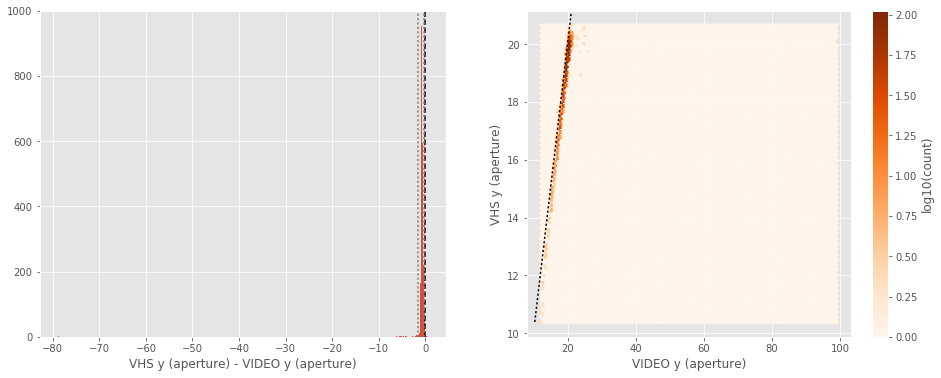

VHS y (total) - VIDEO y (total):
- Median: -0.60
- Median Absolute Deviation: 0.15
- 1% percentile: -1.3715890884399415
- 99% percentile: 0.603688049316399


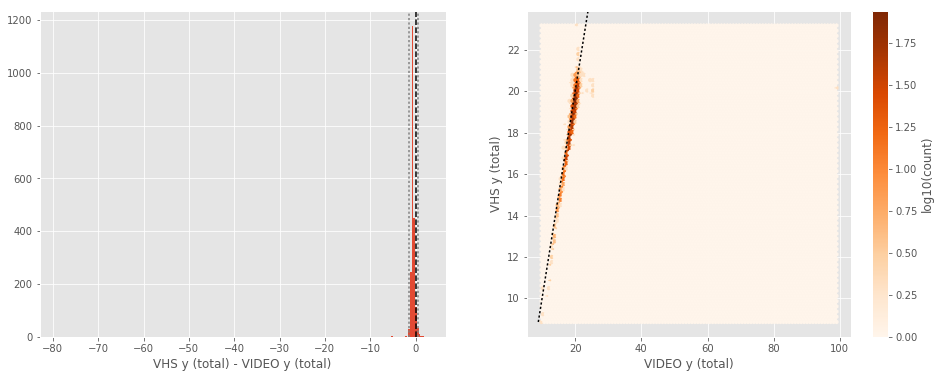

In [9]:
for band_of_a_kind in [u_bands, g_bands, r_bands, i_bands, z_bands, y_bands]:
    for band1, band2 in itertools.combinations(band_of_a_kind, 2):
        
        basecol1, basecol2 = band1.replace(" ", "_").lower(), band2.replace(" ", "_").lower()
        
        col1, col2 = "m_ap_{}".format(basecol1), "m_ap_{}".format(basecol2)
        nb_compare_mags(master_catalogue[col1], master_catalogue[col2], 
                        labels=("{} (aperture)".format(band1), "{} (aperture)".format(band2)))
        
        col1, col2 = "m_{}".format(basecol1), "m_{}".format(basecol2)
        nb_compare_mags(master_catalogue[col1], master_catalogue[col2], 
                        labels=("{} (total)".format(band1), "{} (total)".format(band2)))

## III - Comparing magnitudes to reference bands

Cross-match the master list to 2MASS to compare magnitudes.

In [10]:
master_catalogue_coords = SkyCoord(master_catalogue['ra'], master_catalogue['dec'])

### III.b - Comparing J and K bands to 2MASS

The catalogue is cross-matched to 2MASS-PSC withing 0.2 arcsecond. We compare the UKIDSS total J and K magnitudes to those from 2MASS.

The 2MASS magnitudes are “*Vega-like*” and we have to convert them to AB magnitudes using the zero points provided on [this page](http://www.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4a.html):

| Band | Fν - 0 mag (Jy) |
|------|-----------------|
| J    | 1594            |
| H    | 1024            |
| Ks   | 666.7           |

In addition, UKIDSS uses a K band whereas 2MASS uses a Ks (“short”) band, [this page](http://www.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4b.html) give a correction to convert the K band in a Ks band with the formula:

$$K_{s(2MASS)} = K_{UKIRT} + 0.003 + 0.004 * (J−K)_{UKIRT}$$

In [11]:
# The AB zero point is 3631 Jy
j_2mass_to_ab = 2.5 * np.log10(3631/1595)
k_2mass_to_ab = 2.5 * np.log10(3631/666.7)

In [12]:
twomass = Table.read("../../dmu0/dmu0_2MASS-point-sources/data/2MASS-PSC_CDFS-SWIRE.fits")
twomass_coords = SkyCoord(twomass['raj2000'], twomass['dej2000'])

idx, d2d, _ = twomass_coords.match_to_catalog_sky(master_catalogue_coords)
mask = (d2d < 0.2 * u.arcsec)

twomass = twomass[mask]
ml_twomass_idx = idx[mask]

VIDEO J (total) - 2MASS J:
- Median: 0.05
- Median Absolute Deviation: 0.07
- 1% percentile: -1.0942424656583618
- 99% percentile: 1.1900690192506889


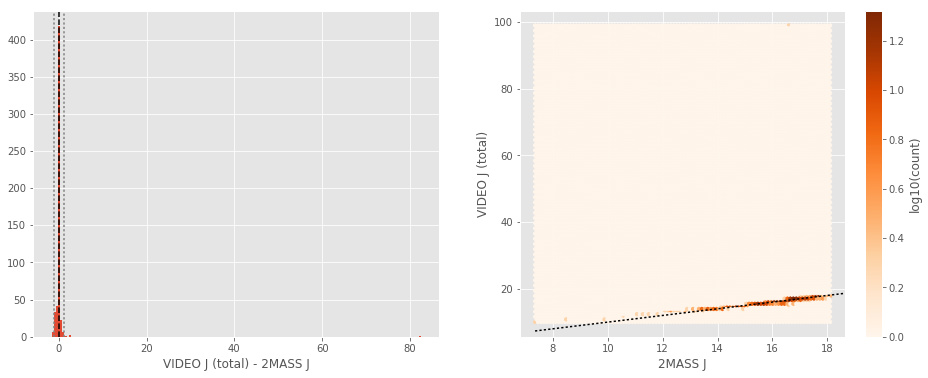

In [13]:
nb_compare_mags(twomass['jmag'] + j_2mass_to_ab, master_catalogue['m_video_j'][ml_twomass_idx],
                labels=("2MASS J", "VIDEO J (total)"))

VIDEO Ks-like (total) - 2MASS Ks:
- Median: 0.05
- Median Absolute Deviation: 0.11
- 1% percentile: -1.0944066665514502
- 99% percentile: 1.2922239455548703


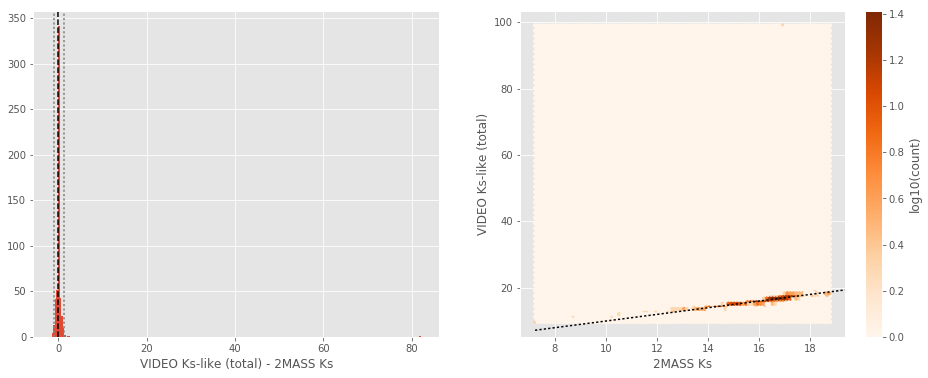

In [14]:
ukidss_ks_like = master_catalogue['m_video_k'] + 0.003 + 0.004 * (
    master_catalogue['m_video_j'] - master_catalogue['m_video_k'])
nb_compare_mags(twomass['kmag'] + k_2mass_to_ab, ukidss_ks_like[ml_twomass_idx],
                labels=("2MASS Ks", "VIDEO Ks-like (total)"))

## IV - Comparing aperture magnitudes to total ones.

Number of source used: 15194 / 295086 (5.15%)


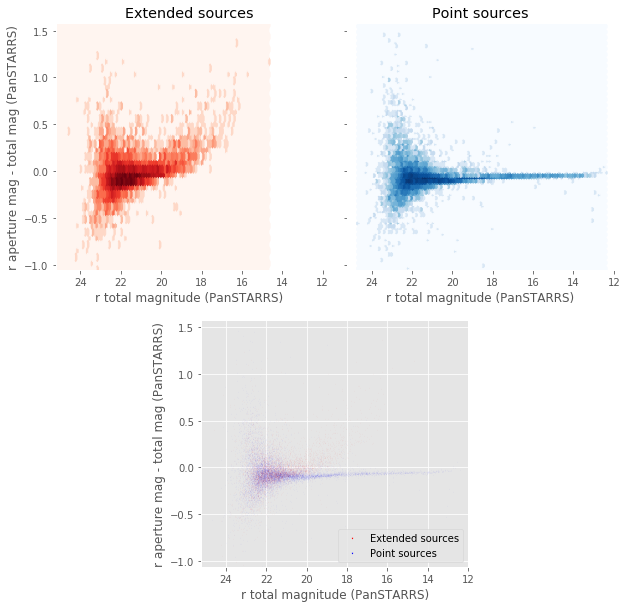

In [15]:
nb_ccplots(
    master_catalogue['m_ps1_r'],
    master_catalogue['m_ap_ps1_r'] - master_catalogue['m_ps1_r'],
    "r total magnitude (PanSTARRS)", "r aperture mag - total mag (PanSTARRS)",
    master_catalogue["stellarity"],
    invert_x=True
)

## V - Color-color and magnitude-color plots

Number of source used: 9325 / 295086 (3.16%)


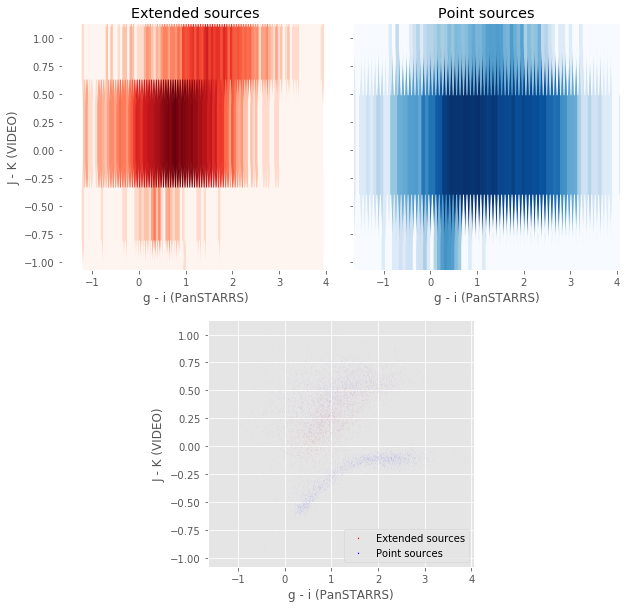

In [16]:
nb_ccplots(
    master_catalogue['m_ps1_g'] - master_catalogue['m_ps1_i'],
    master_catalogue['m_video_j'] - master_catalogue['m_video_k'],
    "g - i (PanSTARRS)", "J - K (VIDEO)",
    master_catalogue["stellarity"]
)

Number of source used: 9258 / 295086 (3.14%)


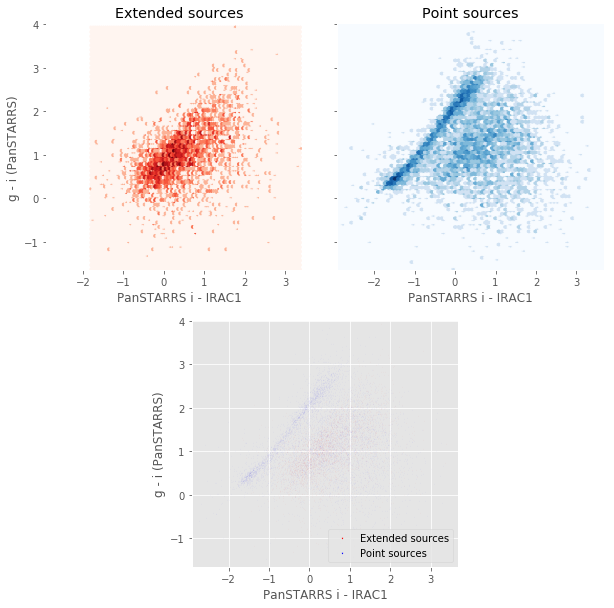

In [17]:
nb_ccplots(
    master_catalogue['m_ps1_i'] - master_catalogue['m_irac1'],
    master_catalogue['m_ps1_g'] - master_catalogue['m_ps1_i'],
    "PanSTARRS i - IRAC1", "g - i (PanSTARRS)",
    master_catalogue["stellarity"]
)

Number of source used: 2568 / 295086 (0.87%)


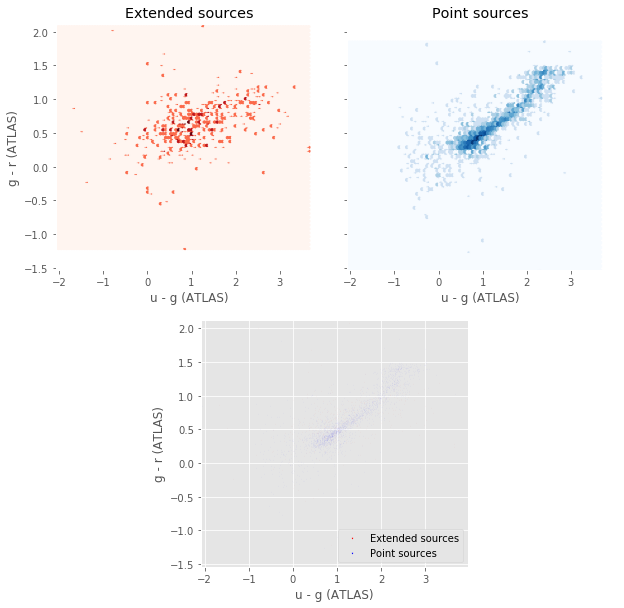

In [18]:
nb_ccplots(
    master_catalogue['m_atlas_u'] - master_catalogue['m_atlas_g'],
    master_catalogue['m_atlas_g'] - master_catalogue['m_atlas_r'],
    "u - g (ATLAS)", "g - r (ATLAS)",
    master_catalogue["stellarity"]
)

Number of source used: 10623 / 295086 (3.60%)


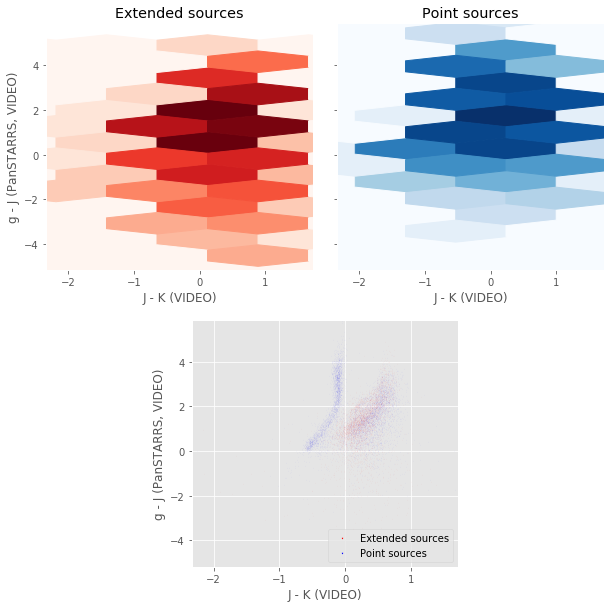

In [19]:
nb_ccplots(
    master_catalogue['m_video_j'] - master_catalogue['m_video_k'],
    master_catalogue['m_ps1_g'] - master_catalogue['m_video_j'],
    "J - K (VIDEO)", "g - J (PanSTARRS, VIDEO)",
    master_catalogue["stellarity"]
)

Number of source used: 16279 / 295086 (5.52%)


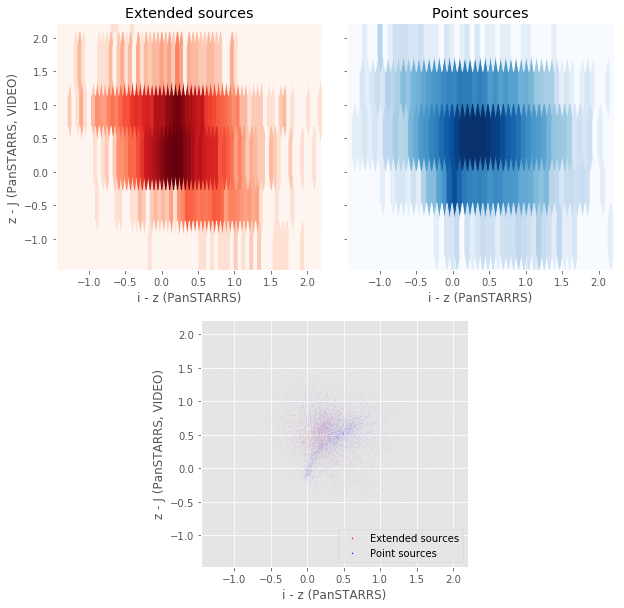

In [20]:
nb_ccplots(
    master_catalogue['m_ps1_i'] - master_catalogue['m_ps1_z'],
    master_catalogue['m_ps1_z'] - master_catalogue['m_video_j'],
    "i - z (PanSTARRS)", "z - J (PanSTARRS, VIDEO)",
    master_catalogue["stellarity"]
)

Number of source used: 3585 / 295086 (1.21%)


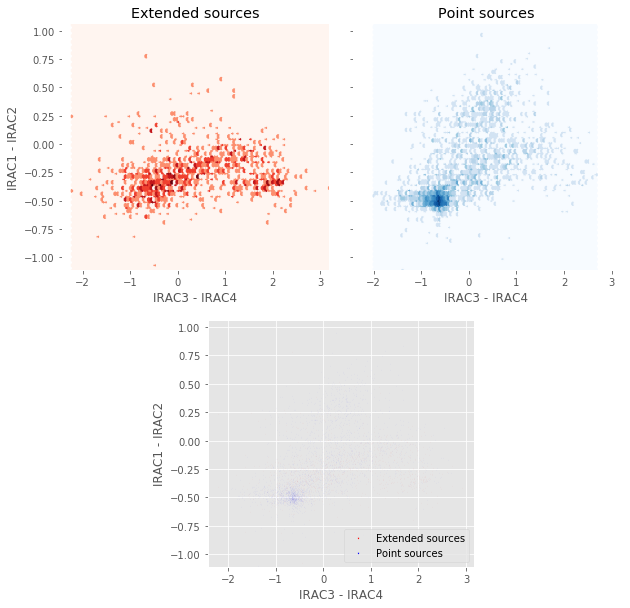

In [21]:
nb_ccplots(
    master_catalogue['m_irac3'] - master_catalogue['m_irac4'],
    master_catalogue['m_irac1'] - master_catalogue['m_irac2'],
    "IRAC3 - IRAC4", "IRAC1 - IRAC2",
    master_catalogue["stellarity"]
)